# Read in data


In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
out = pd.read_csv('output_clean.csv')
out.head()

,Unnamed: 0,1433B_HUMAN,1433E_HUMAN,1433F_HUMAN,1433G_HUMAN,1433S_HUMAN,1433T_HUMAN,1433Z_HUMAN,2AAA_HUMAN,2ABA_HUMAN,...,ZN346_HUMAN,ZNF76_HUMAN,dt_start,dt_end,dose,group,age,sex,gr,suicide
0,113,-0.482358,-0.377167,0.408312,0.114755,-0.221734,-0.094979,-0.594402,-0.062665,0.075711,...,-0.506843,-0.233866,80515,82115,2,c,66,Male,C,Non-Suic
1,113,0.096314,-0.390258,-0.416978,0.361850,0.423957,0.183221,-0.161553,0.100186,0.614246,...,0.445916,0.029326,80515,83115,4,c,66,Male,C,Non-Suic
2,118,-0.127514,-0.350314,-0.907252,-0.798618,0.550538,-0.218804,-0.341688,-0.062510,-0.507460,...,1.198785,-0.748341,80515,90215,5,a,31,Female,MDD*SSRI,Suicide
3,118,-0.152157,-0.371558,-0.563748,-0.657674,0.321579,0.207347,-0.543700,-0.262971,-0.448623,...,1.111894,-0.128839,80515,91515,5,a,31,Female,MDD*SSRI,Suicide
4,178,-1.060055,-0.727050,-0.939338,-0.886080,-1.450801,-0.603545,-1.155046,-0.872522,-1.008205,...,-0.319368,-0.137329,80515,82115,2,c,25,Male,C,Non-Suic


In [4]:
# Check for Missing data (none)
missing_percentage = out.isnull().sum() * 100 / len(out)
missing_percentage[missing_percentage != 0]

Series([], dtype: float64)

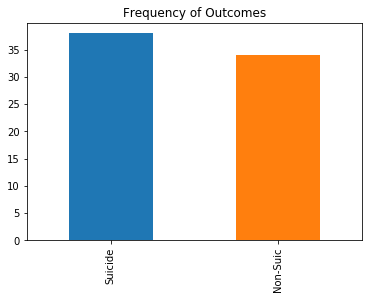

In [5]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Count of suicide/non-suicide
out.suicide.value_counts().plot(kind = 'bar', title = 'Frequency of Outcomes')

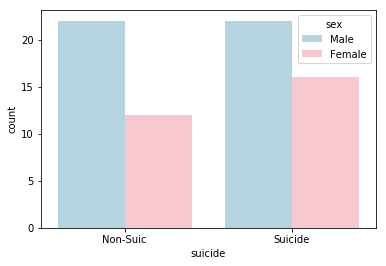

In [6]:
# Suicide/non-suicide broken down by gender

ax = sns.countplot(x="suicide", hue="sex", data=out, palette = ['lightblue', 'pink'])

Text(0.5,0,'Age')

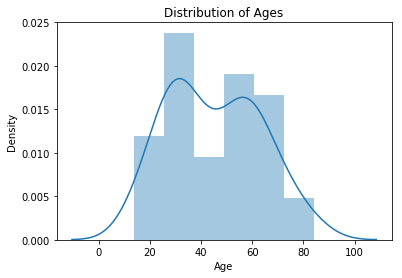

In [7]:
# distribution of ages

ax = sns.distplot(out['age'])
ax.set_title('Distribution of Ages')
ax.set_ylabel('Density')
ax.set_xlabel('Age')

Text(0.5,1,'Gender Frequency across Treatments')

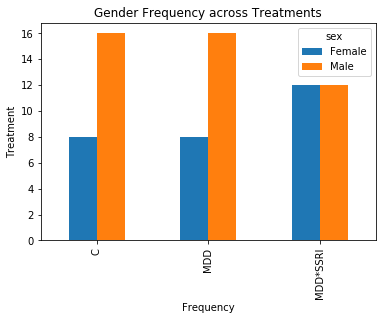

In [8]:
# Gender freq across treatments 

ct = pd.crosstab(out.gr,out.sex)
ax = ct.plot.bar()
ax.set_xlabel('Frequency')
ax.set_ylabel('Treatment')
ax.set_title('Gender Frequency across Treatments')

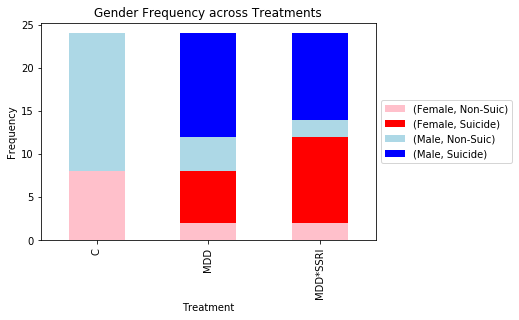

In [9]:
ct = pd.crosstab(out.gr,[out.sex, out.suicide])
ax = ct.plot.bar(stacked = True, color = ['pink', 'red', 'lightblue', 'blue'])
ax.set_ylabel('Frequency')
ax.set_xlabel('Treatment')
ax.set_title('Gender Frequency across Treatments')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [10]:
#Two sample T-test between groups A, B
# Ho: No diff between protein concentrations amongst control and mdd
# Ha: Diff in protein concentrations

from scipy import stats

group1 = 'C'
group2 = 'MDD'

def ttest_all_proteins(group1, group2):
    print('Running 2 sample t-test for ' + group1 + ' and ' + group2 + ' ...')
    d = {}
    stat_sig_proteins = []
    for col in out.columns[0:-8]: # iterate through all protein columns (non-demographic)
        control = out[out['gr'] == group1][col]
        mdd = out[out['gr'] == group2][col]
        p_val = stats.ttest_ind(control,mdd)[1]
        if p_val < 0.05:
            stat_sig_proteins.append(col)
        d[col] = p_val
    return d, stat_sig_proteins

In [11]:
# Grabs the len of first output => len of dictionary filled with p-value results of ttest for each protein
len(ttest_all_proteins(group1, group2)[0])

Running 2 sample t-test for C and MDD ...


1132

In [12]:
# Return len of the second output => the groups have stat sig diff prot. concentrations for these proteins
len(ttest_all_proteins(group1, group2)[1])

Running 2 sample t-test for C and MDD ...


48

In [13]:
# We can also do an ANOVA across three groups to see if there is a stat sig diff in means of the prot concentrations

group1 = 'C'
group2 = 'MDD'
group3 = 'MDD*SSRI'

print('Running Anova test for ' + group1 + ', ' + group2 + ', and ' + group3 + ' ...')
d_anova = {}
stat_sig_proteins_anova = []
for col in out.columns[0:-8]:
    control = out[out['gr'] == group1][col]
    mdd = out[out['gr'] == group2][col]
    mdd_ssri = out[out['gr'] == group3][col]
    
    p_val = stats.f_oneway(control,mdd, mdd_ssri)[1]
    if p_val < 0.05:
        stat_sig_proteins_anova.append(col)
    d_anova[col] = p_val


Running Anova test for C, MDD, and MDD*SSRI ...


In [14]:
# stat_sig_proteins_anova contains list of proteins that has stat sig diff in concentrations btw 2 groups

len(stat_sig_proteins_anova)

153

In [15]:
# More analysis: remove dates

out_no_dates = out.drop(columns=['dt_start', 'dt_end', 'group'])

In [16]:
# One hot encoding and drop original columns

cat_cols = ['dose', 'sex', 'gr']
out_tmp = pd.concat([out_no_dates,pd.get_dummies(out_no_dates[cat_cols])],axis=1)
out_new = out_tmp.drop(['dose', 'sex', 'gr'], axis = 1)

In [17]:
# Change suicide column to 0,1s
out_new.loc[out_new['suicide'] == 'Non-Suic','suicide'] = 0
out_new.loc[out_new['suicide'] == 'Suicide','suicide'] = 1

# Check one-hot encoding in suicide column
out_new['suicide'][0:5]

C:\Users\Michelle Chen\Anaconda2\envs\coms007\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0    0
1    0
2    1
3    1
4    0
Name: suicide, dtype: int64

In [18]:
df1 = out_new.pop('suicide') # remove column suicide and store it in df1
out_new['suicide']=df1 # add suicide series as a 'new' column.

C:\Users\Michelle Chen\Anaconda2\envs\coms007\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
list(out_new.columns).index('suicide')

1138

In [20]:
# Feature importances using Extra Trees Classifier

from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_estimators=100)
model.fit(out_new.iloc[:,0:-1], out_new.suicide)
df = pd.DataFrame(model.feature_importances_)
df.index = out_new.columns[:-1]
df.columns = ['Feature_importance']
d_f = df.sort_values(['Feature_importance'], ascending = False)
top_ten = d_f.head(10)

In [21]:
top_ten

,Feature_importance
gr_C,0.025586
gr_MDD*SSRI,0.011956
gr_MDD,0.010907
MA2A1_HUMAN,0.005254
SBDS_HUMAN,0.005002
FGF9_HUMAN,0.004955
RB6I2_HUMAN,0.004770
PRS8_HUMAN,0.004714
HPT_HUMAN,0.004617
RB11A_HUMAN,0.004525


Text(0.5,1,'Top 10 Feature Importances')

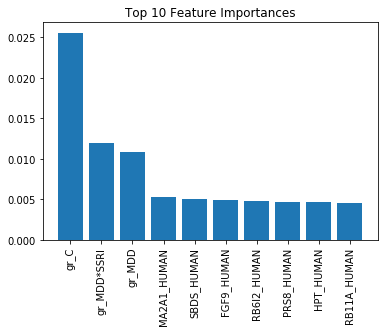

In [22]:
plt.figure()
plt.bar(top_ten.index, top_ten['Feature_importance'])
plt.xticks(rotation = 'vertical')
plt.title('Top 10 Feature Importances')